# ModelSelection.ipynb
## Choosing the number of states and a suitable timescale for hidden Markov models

One of the challenges associated with using hidden Markov models is specifying the correct model. For example, how many hidden states should the model have? At what timescale should we bin our observations? How much data do we need in order to train an effective/useful/representative model?

One possibility (which is conceptually very appealing) is to use a nonparametric Bayesian extension to the HMM, the HDP-HMM (hierarchical Dirichlet process hidden Markov model), in which the number of states can be directly inferred from the data, and moreover, where the number of states are allowed to grow as we obtain more and more data.

Fortunately, even if we choose to use a simple HMM, model selection is perhaps not as important as one might at first think. More specifically, we will show that for a wide range of model states, and for a wide range of timescales, the HMM should return plausible and usable models, so that we can use them to learn something about the data even if we don't have a good idea of what the model parameters should be.

Nevertheless, shifting over to the HDP-HMMs and especially to the HDP-HSMMs (semi-Markov models) where state durations are explicitly specified or learned, is certainly something that I would highly recommend.


### Import packages and initialization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

from IPython.display import display, clear_output

sys.path.insert(0, 'helpers')

from efunctions import * # load my helper function(s) to save pdf figures, etc.
from hc3 import load_data, get_sessions
from hmmlearn import hmm # see https://github.com/ckemere/hmmlearn
import klabtools as klab
import seqtools as sq

import importlib

importlib.reload(sq) # reload module here only while prototyping...
importlib.reload(klab) # reload module here only while prototyping...

%matplotlib inline

sns.set(rc={'figure.figsize': (12, 4),'lines.linewidth': 1.5})
sns.set_style("white")

function saveFigure(filename) loaded

Tip: to save a figure, call saveFigure("path/figure.pdf")


### Load data
Here we consider lin2 data for gor01 on the first recording day (6-7-2006), since this session had the most units (91) of all the gor01 sessions, and lin2 has position data, whereas lin1 only has partial position data.

In [2]:
datadirs = ['/home/etienne/Dropbox/neoReader/Data',
            'C:/etienne/Dropbox/neoReader/Data',
            '/Users/etienne/Dropbox/neoReader/Data']

fileroot = next( (dir for dir in datadirs if os.path.isdir(dir)), None)

animal = 'gor01'; month,day = (6,7); session = '16-40-19' # 91 units

spikes = load_data(fileroot=fileroot, datatype='spikes',animal=animal, session=session, month=month, day=day, fs=32552, verbose=False)
eeg = load_data(fileroot=fileroot, datatype='eeg', animal=animal, session=session, month=month, day=day,channels=[0,1,2], fs=1252, starttime=0, verbose=False)
posdf = load_data(fileroot=fileroot, datatype='pos',animal=animal, session=session, month=month, day=day, verbose=False)
speed = klab.get_smooth_speed(posdf,fs=60,th=8,cutoff=0.5,showfig=False,verbose=False)

reading position data from '/Users/etienne/Dropbox/neoReader/Data/gor01-6-7/2006-6-7_16-40-19/2006-6-7_16-40-19.whl'


## Find most appropriate number of states using cross validation
Here we split the data into **training**, **validation**, and **test** sets. We monitor the average log probability per sequence (normalized by length) for each of these sets, and we use the **validation** set to choose the number of model states $m$. 

**Note to self:** I should re-write my data splitting routines to allow me to extract as many subsets as I want, so that I can do k-fold cross validation.



In [35]:
## bin ALL spikes
ds = 0.125 # bin spikes into 125 ms bins (theta-cycle inspired)
binned_spikes_all = klab.bin_spikes(spikes.data, ds=ds, fs=spikes.samprate, verbose=True)

## identify boundaries for running (active) epochs and then bin those observations into separate sequences:
runbdries = klab.get_boundaries_from_bins(eeg.samprate,bins=speed.active_bins,bins_fs=60)
binned_spikes_bvr = klab.bin_spikes(spikes.data, fs=spikes.samprate, boundaries=runbdries, boundaries_fs=eeg.samprate, ds=ds)

binning data into 20703 x 125.0 ms temporal bins...


In [36]:
## stack data for hmmlearn:
seq_stk_bvr = sq.data_stack(binned_spikes_bvr, verbose=True)
seq_stk_all = sq.data_stack(binned_spikes_all, verbose=True)

## split data into train, test, and validation sets:
tr_b,vl_b,ts_b = sq.data_split(seq_stk_bvr, tr=60, vl=20, ts=20, randomseed = 0, verbose=False)

90 sequences being stacked...
Total sequence length: 1938 bins, each of width 0.125 seconds
Successfully stacked 90 sequences for a total of 242.25 seconds of data.
Only one sequence in data; so data is already in stacked format...


In [37]:
Smax = 40
S = np.arange(start=5,step=1,stop=Smax+1)

tr_ll = []
vl_ll = []
ts_ll = []

for num_states in S:
    clear_output(wait=True)
    print('Training and evaluating {}-state hmm'.format(num_states))
    sys.stdout.flush()
    myhmm = sq.hmm_train(tr_b, num_states=num_states, n_iter=30, verbose=False)
    tr_ll.append( (np.array(list(sq.hmm_eval(myhmm, tr_b)))/tr_b.sequence_lengths ).mean())
    vl_ll.append( (np.array(list(sq.hmm_eval(myhmm, vl_b)))/vl_b.sequence_lengths ).mean())
    ts_ll.append( (np.array(list(sq.hmm_eval(myhmm, ts_b)))/ts_b.sequence_lengths ).mean())

clear_output(wait=True)
print('Done!')
sys.stdout.flush()

Done!


(5, 40)

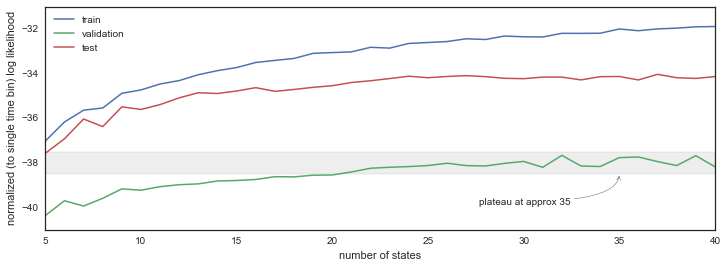

In [38]:
num_states = 35

fig = plt.figure(1, figsize=(12, 4))
ax = fig.add_subplot(111)
    
ax.annotate('plateau at approx ' + str(num_states), xy=(35, -38.5), xycoords='data',
                xytext=(-140, -30), textcoords='offset points',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="angle3,angleA=0,angleB=-90"),
                )

ax.plot(S, tr_ll, lw=1.5, label='train')
ax.plot(S, vl_ll, lw=1.5, label='validation')
ax.plot(S, ts_ll, lw=1.5, label='test')
ax.legend(loc=2)
ax.set_xlabel('number of states')
ax.set_ylabel('normalized (to single time bin) log likelihood')

ax.axhspan(-38.5, -37.5, facecolor='0.75', alpha=0.25)
ax.set_xlim([5, S[-1]])

**Remarks:** We see that the training error is decreasing (equivalently, the training log probability is increasing) over the entire range of states considered. Indeed, we have computed this for a much larger number of states, and the training error keeps on decreasing, whereas both the validation and test errors reach a plateau at around 30 or 35 states.

As expected, the training set has the largest log probability (best agreement with model), but we might expect the test and validation sets to be about the same. For different subsets of our data this is indeed the case, but the more important thing in model selection is that the validation and test sets should have the same _shape_ or behavior, so that we can choose an appropriate model parameter.

However, if we wanted to _predict_ what our log probability for any given sequence would be, then we probably need a little bit more data, for which the test and validation errors should agree more.

Finally, we have also repeated the above analysis when we restricted ourselves to _only using place cells_ in the model, and although the log probabilities were uniformly increased to around $-7$ or $-8$, the overall shape and characteristic behavior were left unchanged, so that model selection could be done either way.

## Place field visualization
Previously we have only considered varying the number of model states for model selection, but of course choosing an appropriate timescale is perhaps just as important. We know, for example, that if our timescale is too short (or fast), then most of the bins will be empty, making it difficult for the model to learn appropriate representations and transitions. On the other hand, if our timescale is too coarse (or long or slow) then we will certainly miss SWR events, and we may even miss some behavioral events as well.

Since theta is around 8 Hz for rodents, it might make sense to consider a timescale of 125 ms or even 62.5 ms for behaviorally relevant events, so that we can hope to capture half or full theta cycles in the observations.

One might also reasonably ask: _"even though the log probability has been optimized, how do we know that the learned model makes any sense? That is, that the model is plausible and useful?"_ One way to try to answer this question is to again consider the place fields that we learn from the data. Place field visualization is considered in more detail in ```StateClustering.ipynb```, but here we simply want to see if we get plausible, behaviorally relevant state representations out when choosing different numbers of states, and different timescales, for example.

### Place fields for varying velocity thresholds
We train our models on RUN data, so we might want to know how sensitive our model is to a specific velocity threshold. Using a smaller threshold will include more quiescent data, and using a larger threshold will exclude more data from being used to learn in the model.

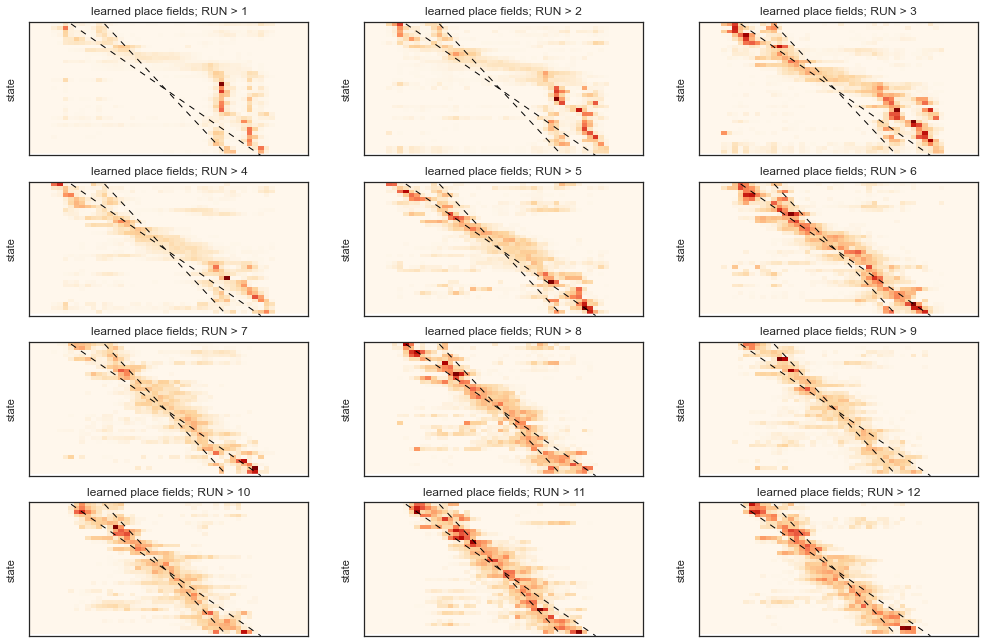

In [3]:
from placefieldviz import hmmplacefieldposviz

num_states = 35
ds = 0.0625 # bin spikes into 62.5 ms bins (theta-cycle inspired)
vth = 8 # units/sec velocity threshold for place fields

#state_pos, peakorder = hmmplacefieldposviz(num_states=num_states, ds=ds, posdf=posdf, spikes=spikes, speed=speed, vth=vth)

fig, axes = plt.subplots(4, 3, figsize=(17, 11))
axes = [item for sublist in axes for item in sublist]

for ii, ax in enumerate(axes):
    vth = ii+1
    state_pos, peakorder = hmmplacefieldposviz(num_states=num_states, ds=ds, posdf=posdf, spikes=spikes, speed=speed, vth=vth, normalize=True, verbose=False)
    ax.matshow(state_pos[peakorder,:], interpolation='none', cmap='OrRd')
    #ax.set_xlabel('position bin')
    ax.set_ylabel('state')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('learned place fields; RUN > ' + str(vth), y=1.02)
    ax.plot([13, 35], [0, num_states], color='k', linestyle='dashed', linewidth=1)
    ax.plot([7, 41], [0, num_states], color='k', linestyle='dashed', linewidth=1)
    ax.axis('tight')

**Remarks:** As can be expected, with low velocity thresholds, we see an overrepresentation of the reward locations, and only a relatively small number of states that are dedicated to encoding the position along the track. 

Recall that the track was shortened halfway through the recording session. Here, the reward locations for the longer track (first half of the experiment) and shorter track (second half of the experiment) are shown by the ends of the dashed lines.

We notice that at some point, the movement velocity (for fixed state evolution) appears to be constant, and that at e.g. 8 units/sec we see a clear bifurcation in the place fields, so that states encode both positions before and after the track was shortened.

### Place fields for varying number of states
Next, we take a look at how the place fields are affected by changing the number of states in the model.

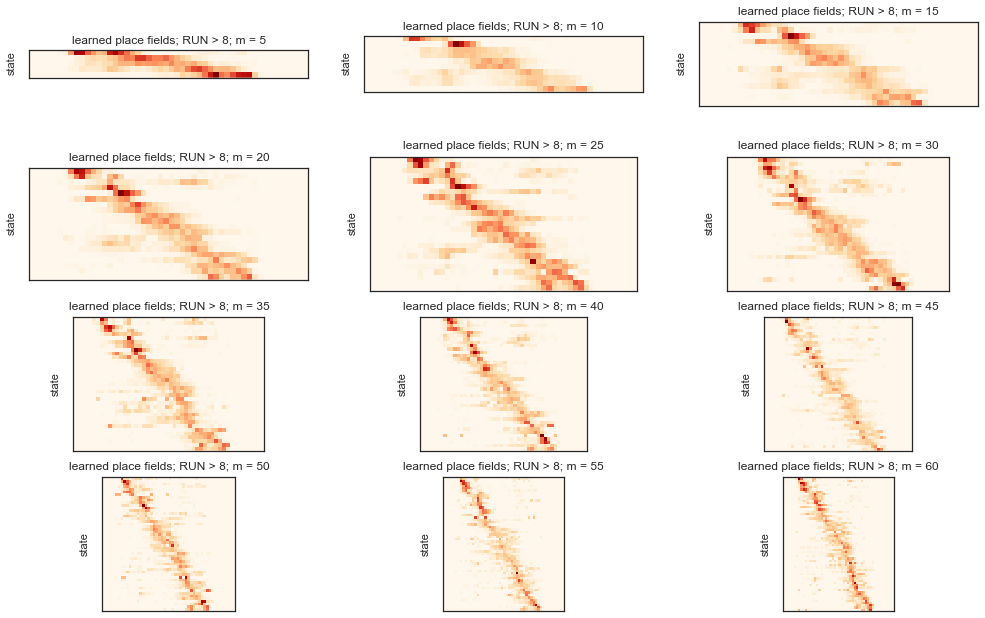

In [6]:
from placefieldviz import hmmplacefieldposviz

num_states = 35
ds = 0.0625 # bin spikes into 62.5 ms bins (theta-cycle inspired)
vth = 8 # units/sec velocity threshold for place fields

#state_pos, peakorder = hmmplacefieldposviz(num_states=num_states, ds=ds, posdf=posdf, spikes=spikes, speed=speed, vth=vth)

fig, axes = plt.subplots(4, 3, figsize=(17, 11))
axes = [item for sublist in axes for item in sublist]

for ii, ax in enumerate(axes):
    num_states = 5 + ii*5
    state_pos, peakorder = hmmplacefieldposviz(num_states=num_states, ds=ds, posdf=posdf, spikes=spikes, speed=speed, vth=vth, normalize=True)
    ax.matshow(state_pos[peakorder,:], interpolation='none', cmap='OrRd')
    #ax.set_xlabel('position bin')
    ax.set_ylabel('state')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('learned place fields; RUN > ' + str(vth) + '; m = ' + str(num_states), y=1.02)

**Remarks:** First, we see that independent of the number of states, the model captures the place field like nature of the underlying states very well. Furthermore, the bifurcation of some states to represent both the first and second halves of the experiment becomes clear with as few as 15 states, but interestingly this bifurcation fades as we add more states to the model, since there is enough flexibility to encode those shifting positions by their own states. 

**Warning:** However, in the case where we have many states so that the states are no longer bimodal, the strict linear ordering that we empose (ordering by peak firing location) can easily mask the underlying structural change in the environment.

### Place fields for varying timescales
Next we investigate how the place fields are affected by changing the timescale of our observations. First, we consider timescales in the range of 31.25 ms to 375 ms, in increments of 31.25 ms.


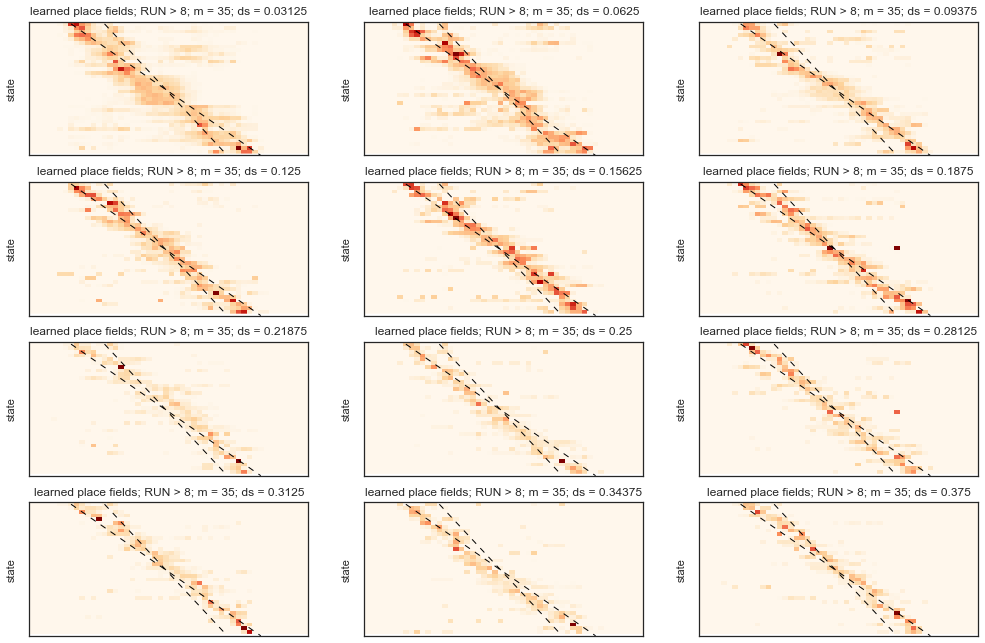

In [11]:
from placefieldviz import hmmplacefieldposviz

num_states = 35
ds = 0.0625 # bin spikes into 62.5 ms bins (theta-cycle inspired)
vth = 8 # units/sec velocity threshold for place fields

#state_pos, peakorder = hmmplacefieldposviz(num_states=num_states, ds=ds, posdf=posdf, spikes=spikes, speed=speed, vth=vth)

fig, axes = plt.subplots(4, 3, figsize=(17, 11))
axes = [item for sublist in axes for item in sublist]

for ii, ax in enumerate(axes):
    ds = (ii+1)*0.03125
    state_pos, peakorder = hmmplacefieldposviz(num_states=num_states, ds=ds, posdf=posdf, spikes=spikes, speed=speed, vth=vth, normalize=True)
    ax.matshow(state_pos[peakorder,:], interpolation='none', cmap='OrRd')
    #ax.set_xlabel('position bin')
    ax.set_ylabel('state')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('learned place fields; RUN > ' + str(vth) + '; m = ' + str(num_states) + '; ds = ' + str(ds), y=1.02)
    ax.plot([13, 35], [0, num_states], color='k', linestyle='dashed', linewidth=1)
    ax.plot([7, 41], [0, num_states], color='k', linestyle='dashed', linewidth=1)
    ax.axis('tight')

**Remarks:** We notice that we clearly see the bimodal place fields when the timescales are sufficiently small, with a particularly clear example at 62.5 ms, for example. Larger timescales tend to focus on the longer track piece, with a single trajectory being skewed away towards the shorter track piece.

Next we consider timescales in increments of 62.5 ms.

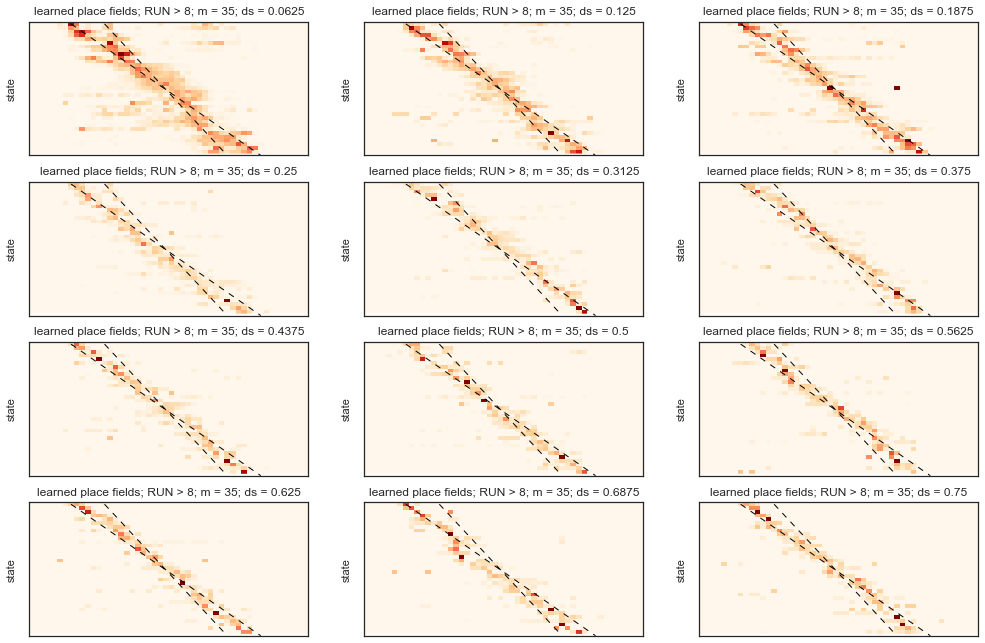

In [12]:
from placefieldviz import hmmplacefieldposviz

num_states = 35
ds = 0.0625 # bin spikes into 62.5 ms bins (theta-cycle inspired)
vth = 8 # units/sec velocity threshold for place fields

#state_pos, peakorder = hmmplacefieldposviz(num_states=num_states, ds=ds, posdf=posdf, spikes=spikes, speed=speed, vth=vth)

fig, axes = plt.subplots(4, 3, figsize=(17, 11))
axes = [item for sublist in axes for item in sublist]

for ii, ax in enumerate(axes):
    ds = (ii+1)*0.0625
    state_pos, peakorder = hmmplacefieldposviz(num_states=num_states, ds=ds, posdf=posdf, spikes=spikes, speed=speed, vth=vth, normalize=True)
    ax.matshow(state_pos[peakorder,:], interpolation='none', cmap='OrRd')
    #ax.set_xlabel('position bin')
    ax.set_ylabel('state')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('learned place fields; RUN > ' + str(vth) + '; m = ' + str(num_states) + '; ds = ' + str(ds), y=1.02)
    ax.plot([13, 35], [0, num_states], color='k', linestyle='dashed', linewidth=1)
    ax.plot([7, 41], [0, num_states], color='k', linestyle='dashed', linewidth=1)
    ax.axis('tight')

**Remarks:** Again, we see that with larger timescales, the spatial resolution becomes more coarse, because we don't have that sufficiently many observations, and the modes of the place fields tend to lie close to those associated wit the longer track.

## Splitting the experimment in half
Just as a confirmation of what we've seen so far, we next consider the place fields obtained when we split the experiment into its first and second halves, correponding to when the track was longer, and shorter, respectively.

In [13]:
from placefieldviz import hmmplacefieldposviz

num_states = 25
ds = 0.0625 # bin spikes into 62.5 ms bins (theta-cycle inspired)
vth = 8 # units/sec velocity threshold for place fields

state_pos_b, peakorder_b = hmmplacefieldposviz(num_states=num_states, ds=ds, posdf=posdf, spikes=spikes, speed=speed, vth=vth, normalize=True, experiment='both')
state_pos_1, peakorder_1 = hmmplacefieldposviz(num_states=num_states, ds=ds, posdf=posdf, spikes=spikes, speed=speed, vth=vth, normalize=True, experiment='first')
state_pos_2, peakorder_2 = hmmplacefieldposviz(num_states=num_states, ds=ds, posdf=posdf, spikes=spikes, speed=speed, vth=vth, normalize=True, experiment='second')

(-0.5, 49.5, 25.0, -0.5)

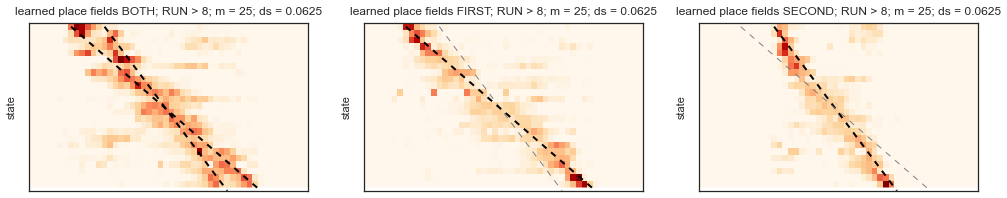

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 3))

ax1.matshow(state_pos_b[peakorder_b,:], interpolation='none', cmap='OrRd')
ax1.set_ylabel('state')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_title('learned place fields BOTH; RUN > ' + str(vth) + '; m = ' + str(num_states) + '; ds = ' + str(ds), y=1.02)
ax1.plot([13, 35], [0, num_states], color='k', linestyle='dashed', linewidth=2)
ax1.plot([7, 41], [0, num_states], color='k', linestyle='dashed', linewidth=2)
ax1.axis('tight')

ax2.matshow(state_pos_1[peakorder_1,:], interpolation='none', cmap='OrRd')
ax2.set_ylabel('state')
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_title('learned place fields FIRST; RUN > ' + str(vth) + '; m = ' + str(num_states) + '; ds = ' + str(ds), y=1.02)
ax2.plot([13, 35], [0, num_states], color='gray', linestyle='dashed', linewidth=1)
ax2.plot([7, 41], [0, num_states], color='k', linestyle='dashed', linewidth=2)
ax2.axis('tight')

ax3.matshow(state_pos_2[peakorder_2,:], interpolation='none', cmap='OrRd')
ax3.set_ylabel('state')
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.set_title('learned place fields SECOND; RUN > ' + str(vth) + '; m = ' + str(num_states) + '; ds = ' + str(ds), y=1.02)
ax3.plot([13, 35], [0, num_states], color='k', linestyle='dashed', linewidth=2)
ax3.plot([7, 41], [0, num_states], color='gray', linestyle='dashed', linewidth=1)
ax3.axis('tight')

**Remarks:** We clearly see the bimodal place fields when we use all of the data, and we see the unimodal place fields emerge as we focus on either the first, or the second half of the experiment.

Notice that the reward locations are more concentrated, but that the velocity (with fixed state progression) is roughly constant.

However, if we increase the number of states:

(-0.5, 49.5, 45.0, -0.5)

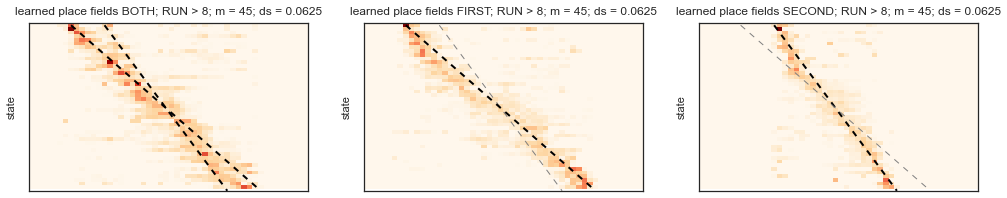

In [15]:
from placefieldviz import hmmplacefieldposviz

num_states = 45
ds = 0.0625 # bin spikes into 62.5 ms bins (theta-cycle inspired)
vth = 8 # units/sec velocity threshold for place fields

state_pos_b, peakorder_b = hmmplacefieldposviz(num_states=num_states, ds=ds, posdf=posdf, spikes=spikes, speed=speed, vth=vth, normalize=True, experiment='both')
state_pos_1, peakorder_1 = hmmplacefieldposviz(num_states=num_states, ds=ds, posdf=posdf, spikes=spikes, speed=speed, vth=vth, normalize=True, experiment='first')
state_pos_2, peakorder_2 = hmmplacefieldposviz(num_states=num_states, ds=ds, posdf=posdf, spikes=spikes, speed=speed, vth=vth, normalize=True, experiment='second')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 3))

ax1.matshow(state_pos_b[peakorder_b,:], interpolation='none', cmap='OrRd')
ax1.set_ylabel('state')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_title('learned place fields BOTH; RUN > ' + str(vth) + '; m = ' + str(num_states) + '; ds = ' + str(ds), y=1.02)
ax1.plot([13, 35], [0, num_states], color='k', linestyle='dashed', linewidth=2)
ax1.plot([7, 41], [0, num_states], color='k', linestyle='dashed', linewidth=2)
ax1.axis('tight')

ax2.matshow(state_pos_1[peakorder_1,:], interpolation='none', cmap='OrRd')
ax2.set_ylabel('state')
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_title('learned place fields FIRST; RUN > ' + str(vth) + '; m = ' + str(num_states) + '; ds = ' + str(ds), y=1.02)
ax2.plot([13, 35], [0, num_states], color='gray', linestyle='dashed', linewidth=1)
ax2.plot([7, 41], [0, num_states], color='k', linestyle='dashed', linewidth=2)
ax2.axis('tight')

ax3.matshow(state_pos_2[peakorder_2,:], interpolation='none', cmap='OrRd')
ax3.set_ylabel('state')
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.set_title('learned place fields SECOND; RUN > ' + str(vth) + '; m = ' + str(num_states) + '; ds = ' + str(ds), y=1.02)
ax3.plot([13, 35], [0, num_states], color='k', linestyle='dashed', linewidth=2)
ax3.plot([7, 41], [0, num_states], color='gray', linestyle='dashed', linewidth=1)
ax3.axis('tight')

then we stat to see the emergence of the S-shaped place field progressions again, indicating that the reward locations are overexpressed by several different states.

This observation is even more pronounced if we increase the number of states further:

(-0.5, 49.5, 100.0, -0.5)

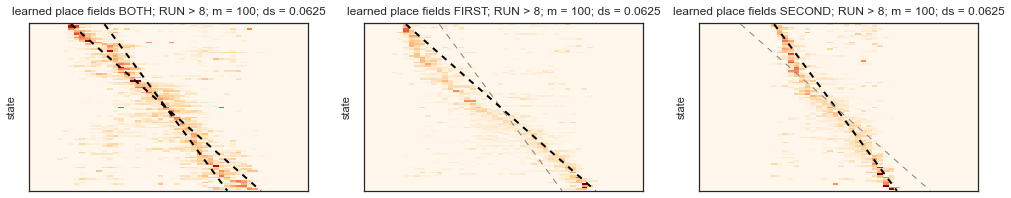

In [33]:
from placefieldviz import hmmplacefieldposviz

num_states = 100
ds = 0.0625 # bin spikes into 62.5 ms bins (theta-cycle inspired)
vth = 8 # units/sec velocity threshold for place fields

state_pos_b, peakorder_b = hmmplacefieldposviz(num_states=num_states, ds=ds, posdf=posdf, spikes=spikes, speed=speed, vth=vth, normalize=True, experiment='both')
state_pos_1, peakorder_1 = hmmplacefieldposviz(num_states=num_states, ds=ds, posdf=posdf, spikes=spikes, speed=speed, vth=vth, normalize=True, experiment='first')
state_pos_2, peakorder_2 = hmmplacefieldposviz(num_states=num_states, ds=ds, posdf=posdf, spikes=spikes, speed=speed, vth=vth, normalize=True, experiment='second')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 3))

ax1.matshow(state_pos_b[peakorder_b,:], interpolation='none', cmap='OrRd')
ax1.set_ylabel('state')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_title('learned place fields BOTH; RUN > ' + str(vth) + '; m = ' + str(num_states) + '; ds = ' + str(ds), y=1.02)
ax1.plot([13, 35], [0, num_states], color='k', linestyle='dashed', linewidth=2)
ax1.plot([7, 41], [0, num_states], color='k', linestyle='dashed', linewidth=2)
ax1.axis('tight')

ax2.matshow(state_pos_1[peakorder_1,:], interpolation='none', cmap='OrRd')
ax2.set_ylabel('state')
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_title('learned place fields FIRST; RUN > ' + str(vth) + '; m = ' + str(num_states) + '; ds = ' + str(ds), y=1.02)
ax2.plot([13, 35], [0, num_states], color='gray', linestyle='dashed', linewidth=1)
ax2.plot([7, 41], [0, num_states], color='k', linestyle='dashed', linewidth=2)
ax2.axis('tight')

ax3.matshow(state_pos_2[peakorder_2,:], interpolation='none', cmap='OrRd')
ax3.set_ylabel('state')
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.set_title('learned place fields SECOND; RUN > ' + str(vth) + '; m = ' + str(num_states) + '; ds = ' + str(ds), y=1.02)
ax3.plot([13, 35], [0, num_states], color='k', linestyle='dashed', linewidth=2)
ax3.plot([7, 41], [0, num_states], color='gray', linestyle='dashed', linewidth=1)
ax3.axis('tight')

With enough expressiveness in the number of states, we see the S-shaped curve reappear, which suggests an overexpression of the reward locations, which is consistent with what we see with place cells in animals.

(-0.5, 49.5, 100.0, -0.5)

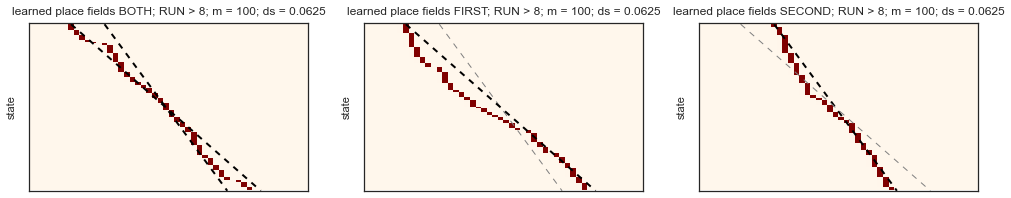

In [34]:
state_pos_b[state_pos_b < np.transpose(np.tile(state_pos_b.max(axis=1),[state_pos_b.shape[1],1]))] = 0
state_pos_b[state_pos_b == np.transpose(np.tile(state_pos_b.max(axis=1),[state_pos_b.shape[1],1]))] = 1
state_pos_1[state_pos_1 < np.transpose(np.tile(state_pos_1.max(axis=1),[state_pos_1.shape[1],1]))] = 0
state_pos_1[state_pos_1 == np.transpose(np.tile(state_pos_1.max(axis=1),[state_pos_1.shape[1],1]))] = 1
state_pos_2[state_pos_2 < np.transpose(np.tile(state_pos_2.max(axis=1),[state_pos_2.shape[1],1]))] = 0
state_pos_2[state_pos_2 == np.transpose(np.tile(state_pos_2.max(axis=1),[state_pos_2.shape[1],1]))] = 1

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 3))

ax1.matshow(state_pos_b[peakorder_b,:], interpolation='none', cmap='OrRd')
ax1.set_ylabel('state')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_title('learned place fields BOTH; RUN > ' + str(vth) + '; m = ' + str(num_states) + '; ds = ' + str(ds), y=1.02)
ax1.plot([13, 35], [0, num_states], color='k', linestyle='dashed', linewidth=2)
ax1.plot([7, 41], [0, num_states], color='k', linestyle='dashed', linewidth=2)
ax1.axis('tight')

ax2.matshow(state_pos_1[peakorder_1,:], interpolation='none', cmap='OrRd')
ax2.set_ylabel('state')
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_title('learned place fields FIRST; RUN > ' + str(vth) + '; m = ' + str(num_states) + '; ds = ' + str(ds), y=1.02)
ax2.plot([13, 35], [0, num_states], color='gray', linestyle='dashed', linewidth=1)
ax2.plot([7, 41], [0, num_states], color='k', linestyle='dashed', linewidth=2)
ax2.axis('tight')

ax3.matshow(state_pos_2[peakorder_2,:], interpolation='none', cmap='OrRd')
ax3.set_ylabel('state')
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.set_title('learned place fields SECOND; RUN > ' + str(vth) + '; m = ' + str(num_states) + '; ds = ' + str(ds), y=1.02)
ax3.plot([13, 35], [0, num_states], color='k', linestyle='dashed', linewidth=2)
ax3.plot([7, 41], [0, num_states], color='gray', linestyle='dashed', linewidth=1)
ax3.axis('tight')

## Discussion
We saw that we actually get meaningful place fields out of a wide range of model parameters, and that the model behaves in an expected, logical way when we add more states, or when we increase the timescale.

Although using the plateau of the log probability on the validation set can be used as a principled, objective way to select the number of states, there are certainly other approaches too, and in particular I would like to pursue the nonparametric Bayesian alternatives.

Nevertheless, I think seeing how robust the learned representations are for such a wide variety of model parameters should give us confidence to use the model in new data sets.